In [16]:
# İmport library
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings


In [17]:
warnings.filterwarnings("ignore")

In [1]:
import os
import zipfile

if not os.path.exists("football-players-data.zip"):
    !kaggle datasets download -d maso0dahmed/football-players-data
    !unzip football-players-data.zip -d football_data


In [3]:
#Define data
data = pd.read_csv("football_data/fifa_players.csv")

In [5]:
#İnfo about data set 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17954 entries, 0 to 17953
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           17954 non-null  object 
 1   full_name                      17954 non-null  object 
 2   birth_date                     17954 non-null  object 
 3   age                            17954 non-null  int64  
 4   height_cm                      17954 non-null  float64
 5   weight_kgs                     17954 non-null  float64
 6   positions                      17954 non-null  object 
 7   nationality                    17954 non-null  object 
 8   overall_rating                 17954 non-null  int64  
 9   potential                      17954 non-null  int64  
 10  value_euro                     17699 non-null  float64
 11  wage_euro                      17708 non-null  float64
 12  preferred_foot                 17954 non-null 

In [6]:
#First 5 values
data.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


## Data Pre-Processing

In [7]:
# Missing Values
data.isna().sum()

name                                 0
full_name                            0
birth_date                           0
age                                  0
height_cm                            0
weight_kgs                           0
positions                            0
nationality                          0
overall_rating                       0
potential                            0
value_euro                         255
wage_euro                          246
preferred_foot                       0
international_reputation(1-5)        0
weak_foot(1-5)                       0
skill_moves(1-5)                     0
body_type                            0
release_clause_euro               1837
national_team                    17097
national_rating                  17097
national_team_position           17097
national_jersey_number           17097
crossing                             0
finishing                            0
heading_accuracy                     0
short_passing            

In [8]:
# Variables with too many missing values are removed from the data set
df = data.drop(columns=["release_clause_euro","national_team","national_rating"
                        ,"national_team_position","national_jersey_number"])

#  Missing values in the value_euro and wage_euro variables are removed.
df = df.dropna()
df.isna().sum().sum()

0

In [9]:
# Unnecessary variables are removed 
remove_columns = ["name","full_name","birth_date","body_type"]

df = df.drop(remove_columns, axis=1)

#Object variables with too many unique values are removed.
df = df.drop(["positions","nationality"], axis=1)

In [10]:
# Correlation Analysis 

# numeric and categorical variables are selected 
numerical_columns = df.select_dtypes(include=["float64","int64"]).columns.tolist()
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()

#The target variable is extracted from the numerical_coulumns variable.
if 'value_euro' in numerical_columns:
    numerical_columns.remove('value_euro')

#Correlation of numerical variables with target variable
correlation_with_target = df[numerical_columns + ["value_euro"]].corr()["value_euro"].sort_values(ascending=False)

# Top 5 high correlation 
top_correlated_numerical = correlation_with_target.head(6)

# mean of the categorical variable with respect to the target variable

categorical_effects = df.groupby("preferred_foot")["value_euro"].mean()

# Printing of Results:
{
    "top_correlated_numerical": top_correlated_numerical,
    "categorical_effects": categorical_effects
}

{'top_correlated_numerical': value_euro                       1.000000
 wage_euro                        0.856466
 international_reputation(1-5)    0.644610
 overall_rating                   0.630928
 potential                        0.576341
 reactions                        0.547615
 Name: value_euro, dtype: float64,
 'categorical_effects': preferred_foot
 Left     2.656160e+06
 Right    2.425613e+06
 Name: value_euro, dtype: float64}

<BarContainer object of 2 artists>

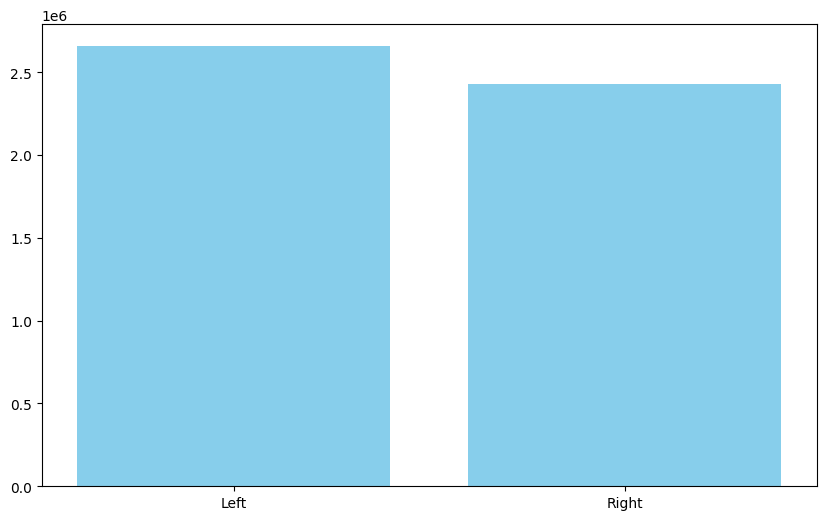

In [ ]:
# Graph of the preferred foot 
plt.figure(figsize=(10, 6))
plt.bar(categorical_effects.index, categorical_effects.values, color='skyblue')

In [12]:
# Since there is very little difference between them, this variable is not needed in the model.
df = df.drop("preferred_foot",axis=1)

In [13]:
# Correlation values
correlation_with_target = correlation_with_target.drop(["value_euro"], axis=0)
correlation_with_target

wage_euro                        0.856466
international_reputation(1-5)    0.644610
overall_rating                   0.630928
potential                        0.576341
reactions                        0.547615
composure                        0.456538
vision                           0.363445
short_passing                    0.329467
skill_moves(1-5)                 0.317427
ball_control                     0.309655
long_passing                     0.306941
volleys                          0.291412
curve                            0.289540
shot_power                       0.284693
long_shots                       0.284085
dribbling                        0.273006
freekick_accuracy                0.268270
positioning                      0.262596
finishing                        0.261003
crossing                         0.251093
penalties                        0.243599
stamina                          0.216471
agility                          0.199008
aggression                       0

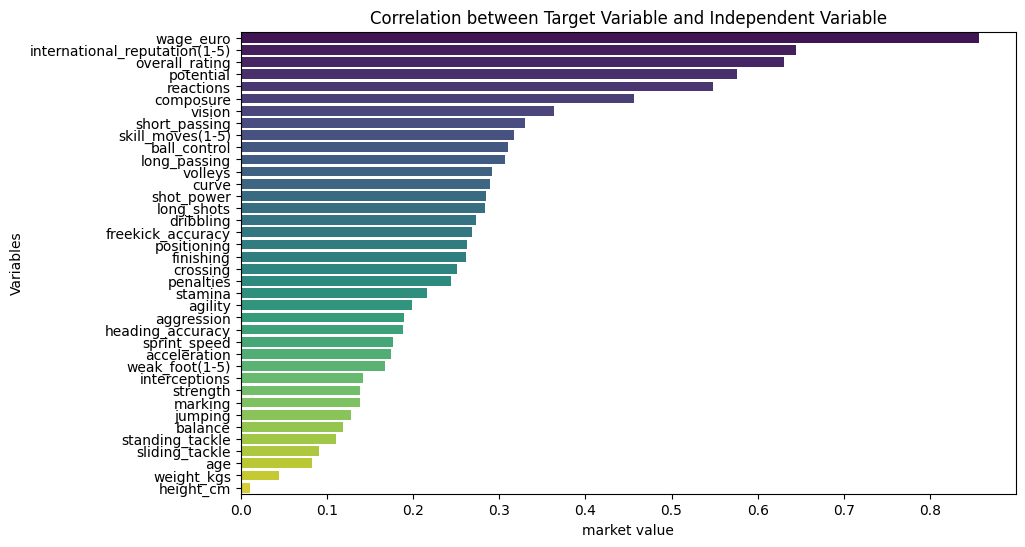

In [19]:
#graph of correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, 
            y=correlation_with_target.index, 
            hue=correlation_with_target.index, 
            palette='viridis', 
            legend=False)  

plt.xlabel('market value')
plt.ylabel('Variables')
plt.title('Correlation between Target Variable and Independent Variable')
plt.show()


## Feature Engineering

In [20]:
#New variables are defined 

df["physic"] = (df["strength"] + df["sprint_speed"] + df["agility"] + df["reactions"] +
                 df["stamina"] + df["jumping"] + df["balance"] + df["acceleration"])/8

df["defense"] = (df["sliding_tackle"] + df["standing_tackle"] + df["interceptions"] +
                 df["marking"] + df["positioning"] + df["aggression"])/6

df["football_skills"] = (df["ball_control"] + df["short_passing"] + df["long_passing"] + 
                         df["composure"] + df["vision"] + df["dribbling"])/6

df["offansive_skills"] = (df["crossing"] + df["finishing"] + df["long_shots"] + df["volleys"] +
                          df["heading_accuracy"])/5